# Assignment 5

## Loaders

In [1]:
from google.colab import drive
import zipfile

drive.mount('/content/drive')

# !unzip  "/content/drive/My Drive/A_05_Part_02_Dataset" -d '/content/drive/My Drive/A_05_Part_02_Dataset'



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
!ls '/content/drive/My Drive/A_05_Part_02_Dataset/A_05_Part_02_Dataset/Train'

covid-19  normal  pneumonia


### Library Imports

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob
import cv2
from tqdm import tqdm
import pandas as pd
from IPython.core.display import display, HTML
from sklearn.metrics import multilabel_confusion_matrix, f1_score 

###Data Directory

In [0]:
data_dir = '/content/drive/My Drive/A_05_Part_02_Dataset/A_05_Part_02_Dataset'

### Data Loading

In [5]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224,interpolation=3),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                                      torchvision.transforms.Resize(size = 224, interpolation=3),
                                      
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
train_data = datasets.ImageFolder(data_dir + '/Train', transform=train_transforms)
validation_data = datasets.ImageFolder(data_dir + '/Validation', transform = train_transforms)
test_data = datasets.ImageFolder(data_dir+ '/Test', transform= test_transforms )

#data loaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=8, shuffle=True, num_workers=5)
testloader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
validationloader = torch.utils.data.DataLoader(validation_data, batch_size=8, shuffle=True, num_workers=5)

print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['covid-19', 'normal', 'pneumonia']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


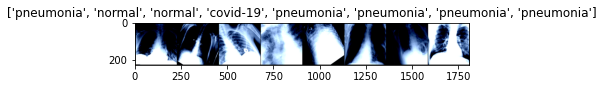

tensor([2, 1, 1, 0, 2, 2, 2, 2])


In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.axis('off')
    plt.imshow(inp,cmap = 'gray')
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(trainloader))
show_databatch(inputs, classes)
print(classes)

In [0]:
classes_name_defined = ['covid-19', 'normal', 'pneumonia']

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Methods

### Test Prediction to CSV

In [0]:
def testing_predictions_to_csv (loader_data, type_of_loader, model_uc):
  predict = []
  img_names = []
  i = 0
  with torch.no_grad():
    for data in tqdm(loader_data, position = 0, leave = True):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model_uc(images)
      predicted = torch.tensor((outputs>0).cpu().numpy().astype('int')).to(device)
      img_names.append( (loader_data.dataset.samples[i][0]).split('/')[-1] )
      predict.extend( predicted.cpu().numpy() )
      i+=1
  testing_results =  {'predictions': predict,'img_names' : img_names}
  my_array = np.array(testing_results['predictions'])

  df = pd.DataFrame(my_array, columns =classes_name_defined)
  df['image_names'] = testing_results['img_names']
  df = df[['image_names','covid-19','pneumonia', 'normal']]
  df.to_csv ('msds19043_results.csv', index = False, header=False)


### Confusion Matrix F1

In [0]:
def Confusion_Matrix_F1 (loader_data, type_of_loader, model_uc):
  correct = 0
  total = 0
  accuracy = 0


  label = []
  predict = []
  one_hot_tr_flag = True if type_of_loader == 'Training' else False

  with torch.no_grad():
    for data in tqdm(loader_data, position = 0, leave = True):
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      outputs = model_uc(images)
      predicted = torch.tensor((outputs>0).cpu().numpy().astype('int')).to(device)
      total += labels.size(0)
      mapper_fnc =  map( accuracy_multiple_label_class,  zip( predicted.cpu().numpy(),
                                                              one_hot(labels,train_flag = one_hot_tr_flag).cpu().numpy() ) )
      
      for i in mapper_fnc:
        correct  += i

      label.extend( list(one_hot(labels,train_flag = one_hot_tr_flag).cpu().numpy()) )
      predict.extend( list(predicted.cpu().numpy()) )
  
  accuracy = correct / total *100
  label = np.array( label)
  predict = np.array(predict)
  
    
  display(HTML('<h3>'+ str(type_of_loader) +'<br></h3>'))
  display(HTML('<h4>Confusion Matrix <br></h4>'))

  f1Score = f1_score(list(label), list(predict), average = 'micro')
  cfm = multilabel_confusion_matrix(list(label), list(predict))
  for i in range(len(cfm)):
    
    df = pd.DataFrame(cfm[i],columns=['Predicted Not '+classes_name_defined[i] ,'Predicted '+classes_name_defined[i]],
                      index = ['Actual Not '+classes_name_defined[i] ,'Actual '+classes_name_defined[i]])
    display(df)

  display(HTML('<h4> F1 Score is : ' + str(f1Score)[:5] +' </h4>'))
  display(HTML('<h4> Accuracy    : ' + str(accuracy)[:5] +' </h4>'))


### Accuracy Calculation

In [0]:
def accuracy_multiple_label_class(inpt):

  return np.divide(  (inpt[0]  == inpt[1] ).astype('int').sum()  ,
                    inpt[0].size )


def calculate_accuracy(loader_data, type_of_loader, model_uc,  return_loss_parameter_criterion = None):
  correct = 0
  total = 0
  accuracy = 0
  loss = 0
  loss_i = 0

  
  
  with torch.no_grad():
    if type_of_loader == 'Testing':
      for data in tqdm(loader_data, position = 0, leave = True):
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_uc(images)
        predicted = torch.tensor((outputs>0).cpu().numpy().astype('int')).to(device)
        total += labels.size(0)
        mapper_fnc =  map( accuracy_multiple_label_class,  zip( predicted.cpu().numpy(),one_hot(labels).cpu().numpy() ) )
        for i in mapper_fnc:
          correct  += i
      print('\n')      
    else:
      for data in loader_data:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model_uc(images)
        predicted = torch.tensor((outputs>0).cpu().numpy().astype('int')).to(device)
        total += labels.size(0)
        tr_flag = True
        if not return_loss_parameter_criterion is None:
          tr_flag = False
          labels_one_hot = one_hot(labels,train_flag =  False)
          t_loss = return_loss_parameter_criterion(outputs, labels_one_hot)
          loss += t_loss.item()
          loss_i +=1
        
        mapper_fnc =  map( accuracy_multiple_label_class,  zip( predicted.cpu().numpy(),
                                                               one_hot(labels,train_flag =  tr_flag).cpu().numpy() ) )
        
        for i in mapper_fnc:
          correct  += i
    accuracy = correct / total *100

    print('\t \t Accuracy %s images: %.1f %%' % ( type_of_loader,
                                             accuracy))
    if not return_loss_parameter_criterion is None:
      return accuracy, loss/loss_i

  return accuracy 



### One Hot Encoding

In [0]:
def one_hot(classes, train_flag = True):
  zer = torch.zeros([list(classes.size())[0], 3])
  for i in range((classes.size())[0]):
    zer[i,classes[i]] = 1
    if train_flag and zer[i, 2] == 1:
      zer[i,0]= 1
  zer = zer.to(device)
  return zer


### Focal Loss

In [0]:

class FocalLoss(nn.Module):
  def __init__(self, gamma=1, alpha=1):
    super(FocalLoss, self).__init__()
    self.gamma = torch.tensor( gamma).to(device)
    self.alpha = torch.tensor( alpha ).to(device)
    self.Loss = nn.BCEWithLogitsLoss().to(device) 

  def forward(self,outputs, labels_one_hot):
    BCE_loss = self.Loss(outputs, labels_one_hot)
    pt = torch.exp(-BCE_loss)
    F_loss =  self.alpha * torch.pow( 1 -pt,self.gamma) * torch.log(BCE_loss)
    return torch.mean(F_loss)



       


### Model Training

In [0]:

def model_training(model_loaded,
                   train_data_loader , validation_data_loader,
                   no_of_epochs, criterion_function,
                   optimizer_function, model_name_to_save,
                   plot_graphs):
  train_accuracy = []
  validation_accuracy = []

  train_loss = []
  validation_loss = []
  # Loss and Optimizer function

  Epochs = no_of_epochs
  criterion = criterion_function
  optimizer = optimizer_function

  trainloader = train_data_loader
  validationloader =  validation_data_loader

  #if you have gpu then you need to convert the network and data to cuda
  #the easiest way is to first check for device and then convert network and data to device
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  model_loaded.to(device)

  

  for epoch in range(Epochs):  # loop over the dataset multiple times
    model_loaded.train()
    loss_i = 0
    running_loss = 0.0
    pbar = tqdm(enumerate(trainloader),  leave=True,position = 0 )
    for i, data in pbar:
    
      # get the inputs
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      # zero the parameter gradients
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation 
      # because PyTorch accumulates the gradients on subsequent backward passes. 
      # This is convenient while training RNNs. 
      # So, the default action is to accumulate the gradients on every loss.backward() call

      # forward + backward + optimize
      outputs = model_loaded(inputs)               #----> forward pass
      labels_one_hot = one_hot(labels)
      loss =  criterion(outputs, labels_one_hot)   #----> compute loss
      loss.backward()                              #----> backward pass
      optimizer.step()                             #----> weights update

      # print statistics
      running_loss += loss.item()
      loss_i +=1
      pbar.set_description(
          'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, i * len(inputs), len(trainloader.dataset),
              100. * i / len(trainloader),
              loss.item() ))

      # print statistics
      running_loss += loss.item()
      loss_i +=1
      pbar.set_description(
          'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, i * len(inputs), len(trainloader.dataset),
              100. * i / len(trainloader),
              loss.item() ))
    train_accuracy.append(calculate_accuracy(trainloader , "Training", model_loaded))

    valAccuracy_rcvd, val_loss_rcvd =  calculate_accuracy(validationloader , "Validation", model_loaded, criterion )
    validation_accuracy.append(valAccuracy_rcvd)

    train_loss.append(running_loss/loss_i)
    validation_loss.append(val_loss_rcvd)



  torch.save(model_loaded.state_dict(), '/content/drive/My Drive/A_05_Part_02_Dataset/weights/'+str(model_name_to_save) +'.pth')

  print('Finished Training')

  if plot_graphs == True:
    plt.figure(figsize =  (16,8))
    plt.title(' Accuracy plot')
    plt.subplot(121)
    plt.plot(np.arange(Epochs), train_accuracy,
             np.arange(Epochs), validation_accuracy
             )
    plt.xlabel('Accuracy')
    plt.ylabel('Epochs')
    plt.legend(labels = ['Train Accuracy','Validation Accuracy'])
    plt.title(' Accuracy over Epochs')
    plt.ylim( (0,100))  
  

    plt.title(' Loss plot')
    plt.subplot(122)
    plt.plot(np.arange(Epochs), train_loss,
             np.arange(Epochs), validation_loss)
    plt.xlabel('Loss')
    plt.ylabel('Epochs')
    plt.legend(labels = ['Train Loss','Validation Loss'])
    plt.title(' Loss over Epochs')

## Experiments

### Exp1 VGG16 FL

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: -0.026861: : 775it [01:26,  8.93it/s]


	 	 Accuracy Training images: 83.1 %
	 	 Accuracy Validation images: 78.2 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: -0.026112: : 775it [01:26,  8.91it/s]


	 	 Accuracy Training images: 85.6 %
	 	 Accuracy Validation images: 80.4 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: -0.026854: : 775it [01:26,  8.96it/s]


	 	 Accuracy Training images: 86.2 %
	 	 Accuracy Validation images: 80.8 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: -0.026867: : 775it [01:27,  8.86it/s]


	 	 Accuracy Training images: 85.2 %
	 	 Accuracy Validation images: 78.3 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: -0.026671: : 775it [01:27,  8.90it/s]


	 	 Accuracy Training images: 86.7 %
	 	 Accuracy Validation images: 79.6 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: -0.026629: : 775it [01:26,  8.99it/s]


	 	 Accuracy Training images: 87.8 %
	 	 Accuracy Validation images: 80.5 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: -0.026752: : 775it [01:26,  9.01it/s]


	 	 Accuracy Training images: 87.1 %
	 	 Accuracy Validation images: 77.8 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: -0.026112: : 775it [01:25,  9.05it/s]


	 	 Accuracy Training images: 86.5 %
	 	 Accuracy Validation images: 78.4 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: -0.026416: : 775it [01:27,  8.81it/s]


	 	 Accuracy Training images: 87.6 %
	 	 Accuracy Validation images: 80.7 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: -0.026841: : 775it [01:26,  8.97it/s]


	 	 Accuracy Training images: 88.7 %
	 	 Accuracy Validation images: 82.7 %


Train Epoch: 10 [6192/6200 (100%)]	Loss: -0.026876: : 775it [01:28,  8.78it/s]


	 	 Accuracy Training images: 88.7 %
	 	 Accuracy Validation images: 81.6 %


Train Epoch: 11 [6192/6200 (100%)]	Loss: -0.025845: : 775it [01:26,  8.91it/s]


	 	 Accuracy Training images: 88.7 %
	 	 Accuracy Validation images: 81.1 %


Train Epoch: 12 [6192/6200 (100%)]	Loss: -0.026369: : 775it [01:30,  8.60it/s]


	 	 Accuracy Training images: 88.4 %
	 	 Accuracy Validation images: 82.6 %


Train Epoch: 13 [6192/6200 (100%)]	Loss: -0.026653: : 775it [01:29,  8.62it/s]


	 	 Accuracy Training images: 88.6 %
	 	 Accuracy Validation images: 80.6 %


Train Epoch: 14 [6192/6200 (100%)]	Loss: -0.026078: : 775it [01:27,  8.87it/s]


	 	 Accuracy Training images: 88.5 %
	 	 Accuracy Validation images: 80.7 %


Train Epoch: 15 [6192/6200 (100%)]	Loss: -0.026836: : 775it [01:24,  9.12it/s]


	 	 Accuracy Training images: 87.2 %
	 	 Accuracy Validation images: 79.3 %


Train Epoch: 16 [6192/6200 (100%)]	Loss: -0.026877: : 775it [01:25,  9.02it/s]


	 	 Accuracy Training images: 88.9 %
	 	 Accuracy Validation images: 81.1 %


Train Epoch: 17 [6192/6200 (100%)]	Loss: -0.026872: : 775it [01:29,  8.66it/s]


	 	 Accuracy Training images: 87.0 %
	 	 Accuracy Validation images: 78.9 %


Train Epoch: 18 [6192/6200 (100%)]	Loss: -0.026877: : 775it [01:28,  8.71it/s]


	 	 Accuracy Training images: 88.5 %
	 	 Accuracy Validation images: 79.8 %


Train Epoch: 19 [6192/6200 (100%)]	Loss: -0.025364: : 775it [01:30,  8.60it/s]


	 	 Accuracy Training images: 88.3 %
	 	 Accuracy Validation images: 81.0 %


  0%|          | 0/775 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:18<00:00,  9.90it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3800,200
Actual covid-19,400,1800


,Predicted Not normal,Predicted normal
Actual Not normal,1816,384
Actual normal,181,3819


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4109,91
Actual pneumonia,924,1076


100%|██████████| 79/79 [00:07<00:00, 10.09it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,416,184
Actual covid-19,13,15


,Predicted Not normal,Predicted normal
Actual Not normal,188,40
Actual normal,16,384


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,421,7
Actual pneumonia,86,114


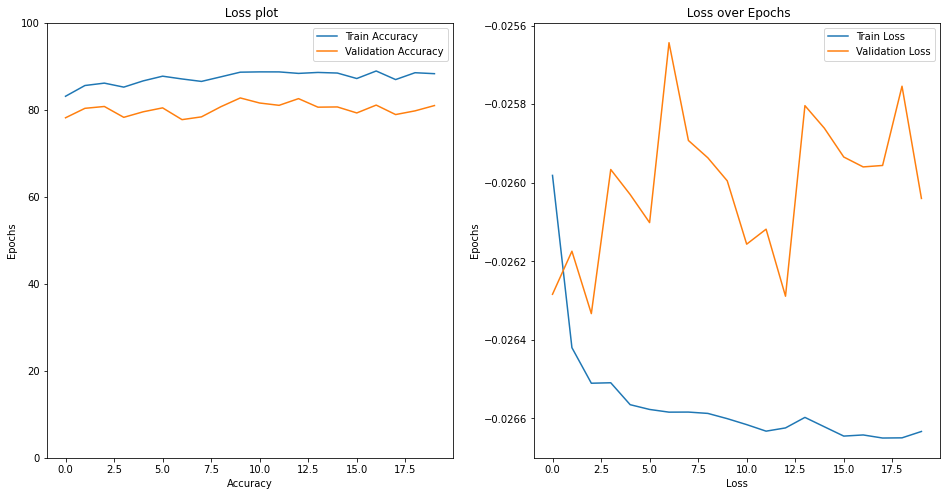

In [21]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =20,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'vgg16_FCLoss',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp2 VGG16 BCELoss

In [0]:
# Load the pretrained model from pytorch
# del vgg16
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.400850: : 775it [01:37,  7.95it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.490627: : 775it [01:38,  7.91it/s]


	 	 Accuracy Training images: 66.1 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: 0.520041: : 775it [01:39,  7.81it/s]


	 	 Accuracy Training images: 66.3 %
	 	 Accuracy Validation images: 75.7 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: 0.606810: : 775it [01:38,  7.83it/s]


	 	 Accuracy Training images: 79.2 %
	 	 Accuracy Validation images: 78.5 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: 0.503953: : 775it [01:39,  7.83it/s]


	 	 Accuracy Training images: 82.0 %
	 	 Accuracy Validation images: 75.3 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: 0.358910: : 775it [01:39,  7.77it/s]


	 	 Accuracy Training images: 85.7 %
	 	 Accuracy Validation images: 79.2 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: 0.395723: : 775it [01:38,  7.87it/s]


	 	 Accuracy Training images: 84.4 %
	 	 Accuracy Validation images: 77.0 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: 0.141077: : 775it [01:38,  7.84it/s]


	 	 Accuracy Training images: 87.9 %
	 	 Accuracy Validation images: 83.1 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: 0.194061: : 775it [01:42,  7.58it/s]


	 	 Accuracy Training images: 85.4 %
	 	 Accuracy Validation images: 82.3 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: 0.437666: : 775it [01:39,  7.77it/s]


	 	 Accuracy Training images: 86.3 %
	 	 Accuracy Validation images: 81.8 %


Train Epoch: 10 [6192/6200 (100%)]	Loss: 0.290263: : 775it [01:42,  7.53it/s]


	 	 Accuracy Training images: 83.5 %
	 	 Accuracy Validation images: 81.7 %


Train Epoch: 11 [6192/6200 (100%)]	Loss: 0.270920: : 775it [01:42,  7.58it/s]


	 	 Accuracy Training images: 83.5 %
	 	 Accuracy Validation images: 73.2 %


Train Epoch: 12 [6192/6200 (100%)]	Loss: 0.385441: : 775it [01:38,  7.86it/s]


	 	 Accuracy Training images: 86.7 %
	 	 Accuracy Validation images: 80.9 %


Train Epoch: 13 [6192/6200 (100%)]	Loss: 0.271499: : 775it [01:37,  7.96it/s]


	 	 Accuracy Training images: 86.6 %
	 	 Accuracy Validation images: 79.4 %


Train Epoch: 14 [6192/6200 (100%)]	Loss: 0.233289: : 775it [01:38,  7.85it/s]


	 	 Accuracy Training images: 89.0 %
	 	 Accuracy Validation images: 82.6 %


Train Epoch: 15 [6192/6200 (100%)]	Loss: 0.443252: : 775it [01:42,  7.53it/s]


	 	 Accuracy Training images: 87.4 %
	 	 Accuracy Validation images: 81.5 %


Train Epoch: 16 [6192/6200 (100%)]	Loss: 0.398057: : 775it [01:42,  7.60it/s]


	 	 Accuracy Training images: 88.3 %
	 	 Accuracy Validation images: 80.8 %


Train Epoch: 17 [6192/6200 (100%)]	Loss: 0.469647: : 775it [01:39,  7.82it/s]


	 	 Accuracy Training images: 86.8 %
	 	 Accuracy Validation images: 81.9 %


Train Epoch: 18 [6192/6200 (100%)]	Loss: 0.330910: : 775it [01:37,  7.91it/s]


	 	 Accuracy Training images: 89.0 %
	 	 Accuracy Validation images: 82.6 %


Train Epoch: 19 [6192/6200 (100%)]	Loss: 0.208337: : 775it [01:40,  7.71it/s]


	 	 Accuracy Training images: 88.6 %
	 	 Accuracy Validation images: 80.9 %


  0%|          | 0/775 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:25<00:00,  9.02it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3589,411
Actual covid-19,252,1948


,Predicted Not normal,Predicted normal
Actual Not normal,1947,253
Actual normal,415,3585


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3675,525
Actual pneumonia,223,1777


100%|██████████| 79/79 [00:09<00:00,  8.77it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,372,228
Actual covid-19,12,16


,Predicted Not normal,Predicted normal
Actual Not normal,198,30
Actual normal,47,353


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,381,47
Actual pneumonia,21,179


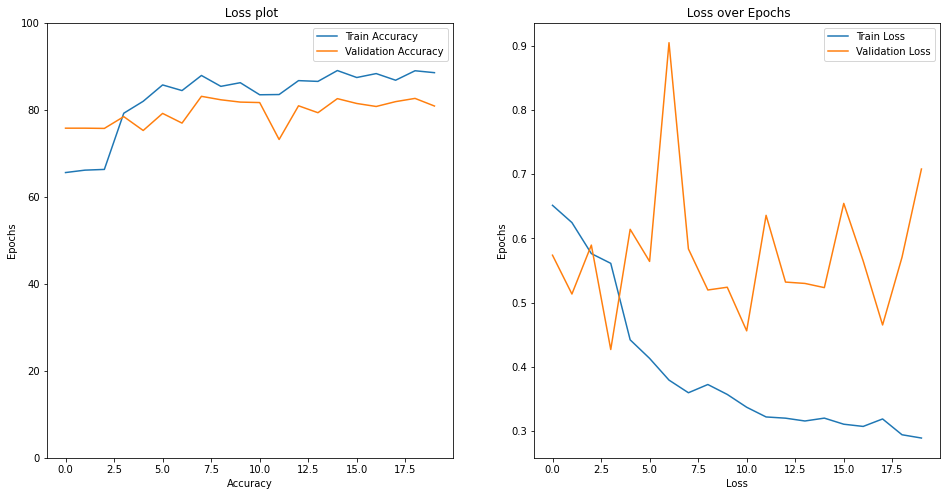

In [19]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =20,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'vgg16_BCELoss',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp3 ResNet18 BCELoss

In [0]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.552163: : 775it [01:24,  9.16it/s]


	 	 Accuracy Training images: 83.5 %
	 	 Accuracy Validation images: 79.0 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.155163: : 775it [01:21,  9.54it/s]


	 	 Accuracy Training images: 85.9 %
	 	 Accuracy Validation images: 80.3 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: 0.386849: : 775it [01:25,  9.06it/s]


	 	 Accuracy Training images: 87.5 %
	 	 Accuracy Validation images: 79.3 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: 0.167068: : 775it [01:24,  9.16it/s]


	 	 Accuracy Training images: 88.7 %
	 	 Accuracy Validation images: 82.0 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: 0.359233: : 775it [01:27,  8.85it/s]


	 	 Accuracy Training images: 88.1 %
	 	 Accuracy Validation images: 79.6 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: 0.254347: : 775it [01:22,  9.40it/s]


	 	 Accuracy Training images: 89.5 %
	 	 Accuracy Validation images: 82.9 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: 0.453384: : 775it [01:27,  8.82it/s]


	 	 Accuracy Training images: 88.4 %
	 	 Accuracy Validation images: 80.1 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: 0.421599: : 775it [01:26,  8.96it/s]


	 	 Accuracy Training images: 89.6 %
	 	 Accuracy Validation images: 82.4 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: 0.053312: : 775it [01:19,  9.78it/s]


	 	 Accuracy Training images: 89.9 %
	 	 Accuracy Validation images: 82.4 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: 0.047568: : 775it [01:23,  9.28it/s]


	 	 Accuracy Training images: 89.5 %
	 	 Accuracy Validation images: 83.7 %


Train Epoch: 10 [6192/6200 (100%)]	Loss: 0.230634: : 775it [01:19,  9.78it/s]


	 	 Accuracy Training images: 91.0 %
	 	 Accuracy Validation images: 82.7 %


Train Epoch: 11 [6192/6200 (100%)]	Loss: 0.410974: : 775it [01:25,  9.10it/s]


	 	 Accuracy Training images: 90.1 %
	 	 Accuracy Validation images: 83.5 %


Train Epoch: 12 [6192/6200 (100%)]	Loss: 0.086544: : 775it [01:20,  9.67it/s]


	 	 Accuracy Training images: 91.3 %
	 	 Accuracy Validation images: 83.6 %


Train Epoch: 13 [6192/6200 (100%)]	Loss: 0.096697: : 775it [01:23,  9.25it/s]


	 	 Accuracy Training images: 90.8 %
	 	 Accuracy Validation images: 84.4 %


Train Epoch: 14 [6192/6200 (100%)]	Loss: 0.071571: : 775it [01:17, 10.04it/s]


	 	 Accuracy Training images: 90.2 %
	 	 Accuracy Validation images: 82.4 %


Train Epoch: 15 [6192/6200 (100%)]	Loss: 0.264737: : 775it [01:22,  9.43it/s]


	 	 Accuracy Training images: 90.1 %
	 	 Accuracy Validation images: 84.3 %


Train Epoch: 16 [6192/6200 (100%)]	Loss: 1.353208: : 775it [01:21,  9.55it/s]


	 	 Accuracy Training images: 91.7 %
	 	 Accuracy Validation images: 85.4 %


Train Epoch: 17 [6192/6200 (100%)]	Loss: 0.084151: : 775it [01:23,  9.28it/s]


	 	 Accuracy Training images: 91.4 %
	 	 Accuracy Validation images: 83.5 %


Train Epoch: 18 [6192/6200 (100%)]	Loss: 0.078314: : 775it [01:21,  9.51it/s]


	 	 Accuracy Training images: 91.4 %
	 	 Accuracy Validation images: 84.4 %


Train Epoch: 19 [6192/6200 (100%)]	Loss: 0.291543: : 775it [01:21,  9.46it/s]


	 	 Accuracy Training images: 91.7 %
	 	 Accuracy Validation images: 84.1 %
Finished Training


  0%|          | 0/775 [00:00<?, ?it/s]


  Confusion Matrices :


100%|██████████| 775/775 [01:11<00:00, 10.81it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3829,171
Actual covid-19,318,1882


,Predicted Not normal,Predicted normal
Actual Not normal,1885,315
Actual normal,176,3824


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3952,248
Actual pneumonia,293,1707


100%|██████████| 79/79 [00:07<00:00, 10.63it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,396,204
Actual covid-19,10,18


,Predicted Not normal,Predicted normal
Actual Not normal,206,22
Actual normal,19,381


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,405,23
Actual pneumonia,15,185


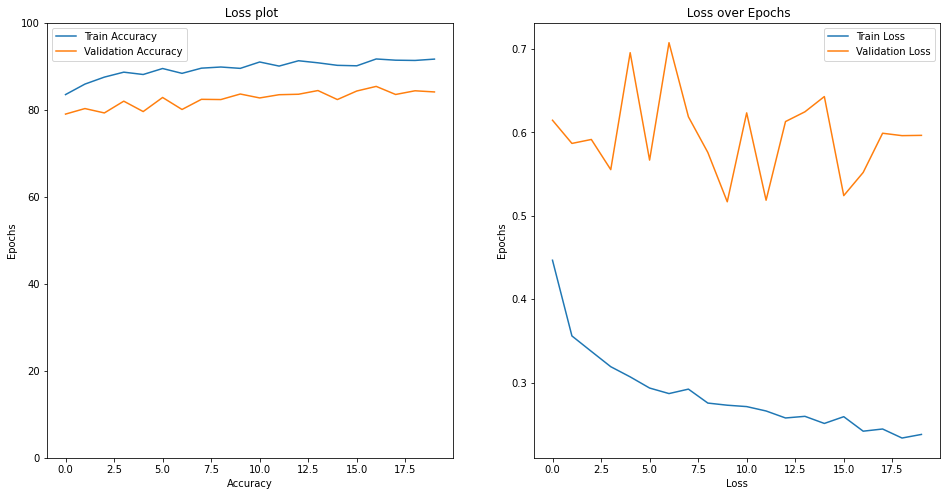

In [21]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =20,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'res18_BCELoss',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp4 ResNet18 FL

In [0]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: -0.026825: : 775it [01:17,  9.99it/s]


	 	 Accuracy Training images: 82.0 %
	 	 Accuracy Validation images: 76.1 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: -0.026761: : 775it [01:18,  9.93it/s]


	 	 Accuracy Training images: 82.6 %
	 	 Accuracy Validation images: 77.9 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: -0.026634: : 775it [01:17,  9.99it/s]


	 	 Accuracy Training images: 83.4 %
	 	 Accuracy Validation images: 77.6 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: -0.024851: : 775it [01:17,  9.94it/s]


	 	 Accuracy Training images: 83.0 %
	 	 Accuracy Validation images: 77.3 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: -0.023718: : 775it [01:17,  9.98it/s]


	 	 Accuracy Training images: 83.7 %
	 	 Accuracy Validation images: 77.8 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: -0.026818: : 775it [01:18,  9.91it/s]


	 	 Accuracy Training images: 82.9 %
	 	 Accuracy Validation images: 74.7 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: -0.026878: : 775it [01:18,  9.93it/s]


	 	 Accuracy Training images: 84.0 %
	 	 Accuracy Validation images: 78.5 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: -0.026673: : 775it [01:17, 10.02it/s]


	 	 Accuracy Training images: 84.6 %
	 	 Accuracy Validation images: 77.9 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: -0.026853: : 775it [01:17,  9.95it/s]


	 	 Accuracy Training images: 84.0 %
	 	 Accuracy Validation images: 76.5 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: -0.026828: : 775it [01:17, 10.01it/s]


	 	 Accuracy Training images: 84.2 %
	 	 Accuracy Validation images: 77.3 %


Train Epoch: 10 [6192/6200 (100%)]	Loss: -0.026863: : 775it [01:17,  9.98it/s]


	 	 Accuracy Training images: 84.2 %
	 	 Accuracy Validation images: 79.0 %


Train Epoch: 11 [6192/6200 (100%)]	Loss: -0.026802: : 775it [01:16, 10.09it/s]


	 	 Accuracy Training images: 84.8 %
	 	 Accuracy Validation images: 79.8 %


Train Epoch: 12 [6192/6200 (100%)]	Loss: -0.026319: : 775it [01:17,  9.95it/s]


	 	 Accuracy Training images: 85.1 %
	 	 Accuracy Validation images: 78.8 %


Train Epoch: 13 [6192/6200 (100%)]	Loss: -0.026736: : 775it [01:18,  9.88it/s]


	 	 Accuracy Training images: 84.2 %
	 	 Accuracy Validation images: 76.5 %


Train Epoch: 14 [6192/6200 (100%)]	Loss: -0.026818: : 775it [01:17, 10.00it/s]


	 	 Accuracy Training images: 84.5 %
	 	 Accuracy Validation images: 78.2 %


Train Epoch: 15 [6192/6200 (100%)]	Loss: -0.026875: : 775it [01:18,  9.89it/s]


	 	 Accuracy Training images: 84.9 %
	 	 Accuracy Validation images: 77.3 %


Train Epoch: 16 [6192/6200 (100%)]	Loss: -0.026879: : 775it [01:17,  9.98it/s]


	 	 Accuracy Training images: 85.8 %
	 	 Accuracy Validation images: 79.7 %


Train Epoch: 17 [6192/6200 (100%)]	Loss: -0.026870: : 775it [01:17,  9.99it/s]


	 	 Accuracy Training images: 84.8 %
	 	 Accuracy Validation images: 77.9 %


Train Epoch: 18 [6192/6200 (100%)]	Loss: -0.026672: : 775it [01:17, 10.04it/s]


	 	 Accuracy Training images: 84.0 %
	 	 Accuracy Validation images: 74.4 %


Train Epoch: 19 [6192/6200 (100%)]	Loss: -0.026778: : 775it [01:17,  9.97it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 78.7 %
Finished Training


  0%|          | 0/775 [00:00<?, ?it/s]


  Confusion Matrices :


100%|██████████| 775/775 [01:12<00:00, 10.63it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3538,462
Actual covid-19,404,1796


,Predicted Not normal,Predicted normal
Actual Not normal,1820,380
Actual normal,462,3538


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4051,149
Actual pneumonia,898,1102


100%|██████████| 79/79 [00:07<00:00, 10.49it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,387,213
Actual covid-19,14,14


,Predicted Not normal,Predicted normal
Actual Not normal,180,48
Actual normal,45,355


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,413,15
Actual pneumonia,86,114


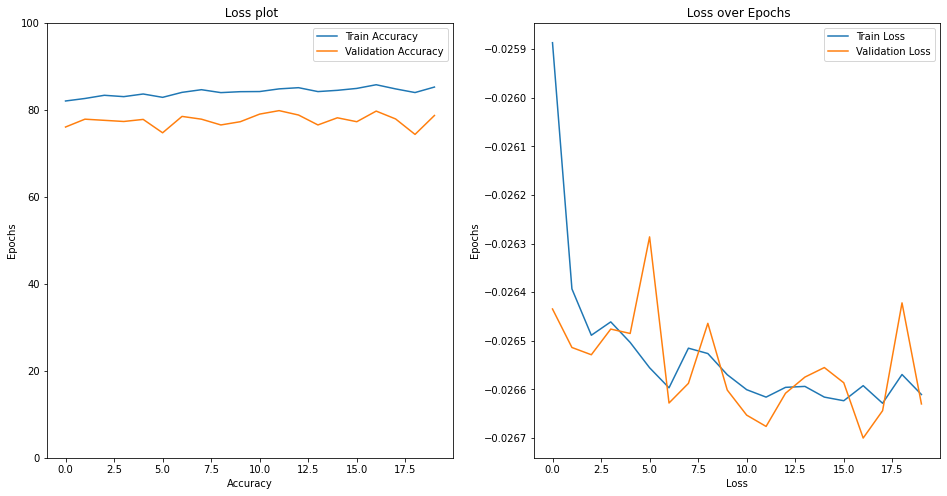

In [23]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =20,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'res18_FCLoss',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp5 VGG16FL lr1e-4

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: -0.024766: : 775it [01:28,  8.79it/s]


	 	 Accuracy Training images: 65.1 %
	 	 Accuracy Validation images: 67.5 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: -0.024341: : 775it [01:29,  8.69it/s]


	 	 Accuracy Training images: 68.8 %
	 	 Accuracy Validation images: 69.5 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: -0.026787: : 775it [01:29,  8.64it/s]


	 	 Accuracy Training images: 71.2 %
	 	 Accuracy Validation images: 72.8 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: -0.026798: : 775it [01:30,  8.56it/s]


	 	 Accuracy Training images: 72.6 %
	 	 Accuracy Validation images: 69.9 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: -0.026845: : 775it [01:29,  8.65it/s]


	 	 Accuracy Training images: 73.5 %
	 	 Accuracy Validation images: 71.4 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: -0.024992: : 775it [01:31,  8.51it/s]


	 	 Accuracy Training images: 73.7 %
	 	 Accuracy Validation images: 72.0 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: -0.026856: : 775it [01:31,  8.45it/s]


	 	 Accuracy Training images: 74.9 %
	 	 Accuracy Validation images: 70.3 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: -0.025050: : 775it [01:33,  8.32it/s]


	 	 Accuracy Training images: 75.0 %
	 	 Accuracy Validation images: 73.0 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: -0.025256: : 775it [01:31,  8.51it/s]


	 	 Accuracy Training images: 75.5 %
	 	 Accuracy Validation images: 73.8 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: -0.022602: : 775it [01:32,  8.38it/s]


	 	 Accuracy Training images: 75.4 %
	 	 Accuracy Validation images: 73.5 %


  0%|          | 0/775 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:18<00:00,  9.93it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3172,828
Actual covid-19,786,1414


,Predicted Not normal,Predicted normal
Actual Not normal,1492,708
Actual normal,781,3219


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3666,534
Actual pneumonia,968,1032


100%|██████████| 79/79 [00:08<00:00,  9.57it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,407,193
Actual covid-19,12,16


,Predicted Not normal,Predicted normal
Actual Not normal,160,68
Actual normal,76,324


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,380,48
Actual pneumonia,98,102


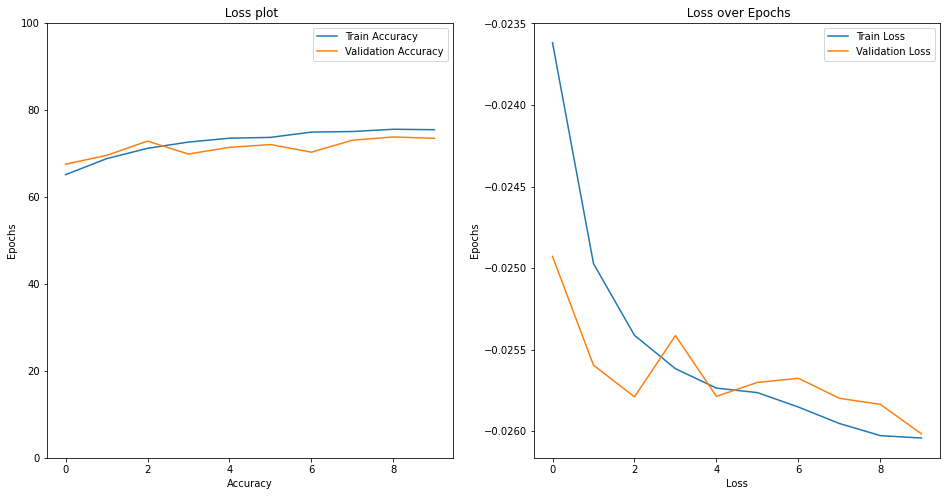

In [24]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-4, momentum=0.9),
               model_name_to_save = 'VGG16_FL_lr1e-4',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp6 VGG16 BCELoss lr1e-4

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.413433: : 775it [01:32,  8.39it/s]


	 	 Accuracy Training images: 87.2 %
	 	 Accuracy Validation images: 81.1 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.271206: : 775it [01:34,  8.24it/s]


	 	 Accuracy Training images: 88.7 %
	 	 Accuracy Validation images: 82.7 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: 0.207221: : 775it [01:37,  7.97it/s]


	 	 Accuracy Training images: 89.6 %
	 	 Accuracy Validation images: 81.7 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: 0.247229: : 775it [01:37,  7.98it/s]


	 	 Accuracy Training images: 90.4 %
	 	 Accuracy Validation images: 83.2 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: 0.311258: : 775it [01:37,  7.94it/s]


	 	 Accuracy Training images: 90.6 %
	 	 Accuracy Validation images: 84.9 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: 0.361808: : 775it [01:38,  7.87it/s]


	 	 Accuracy Training images: 91.0 %
	 	 Accuracy Validation images: 84.0 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: 0.049994: : 775it [01:38,  7.90it/s]


	 	 Accuracy Training images: 91.3 %
	 	 Accuracy Validation images: 84.4 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: 0.144249: : 775it [01:38,  7.89it/s]


	 	 Accuracy Training images: 91.4 %
	 	 Accuracy Validation images: 84.2 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: 0.149730: : 775it [01:39,  7.78it/s]


	 	 Accuracy Training images: 91.6 %
	 	 Accuracy Validation images: 84.1 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: 0.132462: : 775it [01:36,  7.99it/s]


	 	 Accuracy Training images: 91.8 %
	 	 Accuracy Validation images: 84.7 %


  0%|          | 0/775 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:25<00:00,  9.05it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3851,149
Actual covid-19,343,1857


,Predicted Not normal,Predicted normal
Actual Not normal,1855,345
Actual normal,148,3852


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3997,203
Actual pneumonia,347,1653


100%|██████████| 79/79 [00:08<00:00,  8.88it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,407,193
Actual covid-19,11,17


,Predicted Not normal,Predicted normal
Actual Not normal,189,39
Actual normal,21,379


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,413,15
Actual pneumonia,29,171


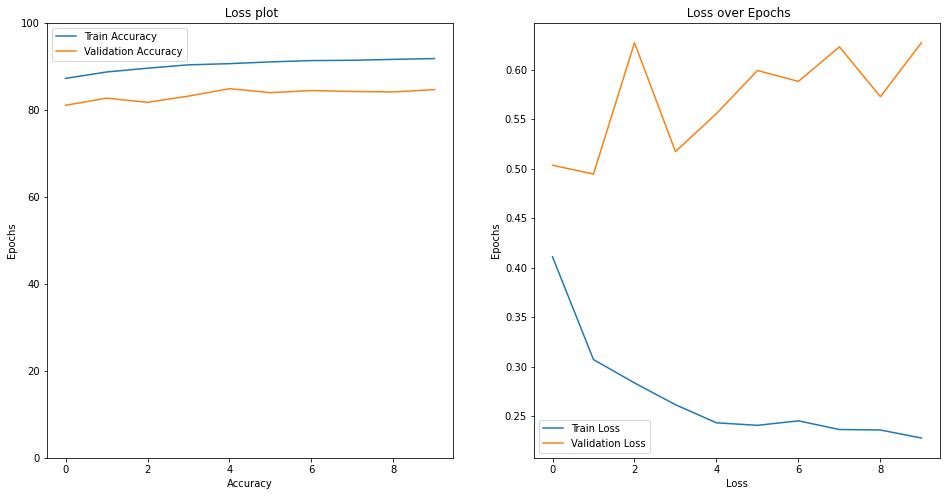

In [26]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-4, momentum=0.9),
               model_name_to_save = 'VGG16_BCELoss_lr1e-4',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp7 ResNet18 BCELoss lr1e-4

In [27]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: 0.454029: : 775it [01:14, 10.35it/s]


	 	 Accuracy Training images: 66.4 %
	 	 Accuracy Validation images: 75.9 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: 0.305468: : 775it [01:15, 10.20it/s]


	 	 Accuracy Training images: 81.9 %
	 	 Accuracy Validation images: 79.9 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: 0.238297: : 775it [01:16, 10.19it/s]


	 	 Accuracy Training images: 84.6 %
	 	 Accuracy Validation images: 78.8 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: 0.518416: : 775it [01:15, 10.30it/s]


	 	 Accuracy Training images: 85.4 %
	 	 Accuracy Validation images: 79.6 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: 0.498502: : 775it [01:15, 10.28it/s]


	 	 Accuracy Training images: 85.7 %
	 	 Accuracy Validation images: 79.6 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: 0.229224: : 775it [01:17,  9.94it/s]


	 	 Accuracy Training images: 86.8 %
	 	 Accuracy Validation images: 80.4 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: 0.372456: : 775it [01:17, 10.02it/s]


	 	 Accuracy Training images: 86.4 %
	 	 Accuracy Validation images: 80.0 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: 0.348020: : 775it [01:17,  9.97it/s]


	 	 Accuracy Training images: 86.9 %
	 	 Accuracy Validation images: 80.5 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: 0.174586: : 775it [01:18,  9.90it/s]


	 	 Accuracy Training images: 87.8 %
	 	 Accuracy Validation images: 79.8 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: 0.287214: : 775it [01:17, 10.04it/s]


	 	 Accuracy Training images: 87.4 %


  0%|          | 0/775 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 81.1 %
Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:13<00:00, 10.60it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3689,311
Actual covid-19,432,1768


,Predicted Not normal,Predicted normal
Actual Not normal,1765,435
Actual normal,300,3700


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3894,306
Actual pneumonia,467,1533


100%|██████████| 79/79 [00:07<00:00, 10.47it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,405,195
Actual covid-19,14,14


,Predicted Not normal,Predicted normal
Actual Not normal,182,46
Actual normal,27,373


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,398,30
Actual pneumonia,41,159


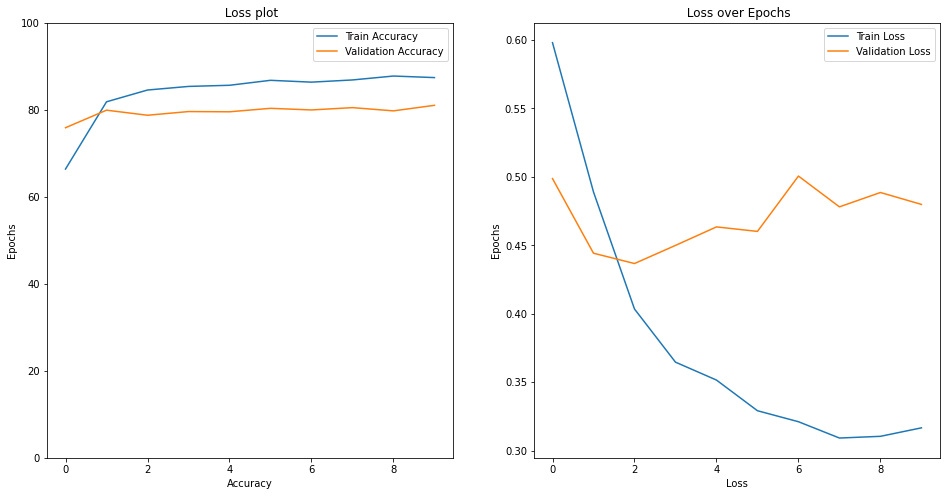

In [28]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-4, momentum=0.9),
               model_name_to_save = 'ResNet18_BCELoss_lr1e-4',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp8 ResNet18 FL lr 1e-4

In [0]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: -0.026561: : 775it [01:14, 10.37it/s]


	 	 Accuracy Training images: 66.4 %
	 	 Accuracy Validation images: 75.4 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: -0.026481: : 775it [01:15, 10.29it/s]


	 	 Accuracy Training images: 66.7 %
	 	 Accuracy Validation images: 74.8 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: -0.024799: : 775it [01:17, 10.06it/s]


	 	 Accuracy Training images: 67.0 %
	 	 Accuracy Validation images: 74.8 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: -0.026152: : 775it [01:16, 10.17it/s]


	 	 Accuracy Training images: 67.4 %
	 	 Accuracy Validation images: 74.7 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: -0.026355: : 775it [01:15, 10.20it/s]


	 	 Accuracy Training images: 67.8 %
	 	 Accuracy Validation images: 75.1 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: -0.023051: : 775it [01:16, 10.16it/s]


	 	 Accuracy Training images: 68.1 %
	 	 Accuracy Validation images: 74.4 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: -0.025876: : 775it [01:14, 10.35it/s]


	 	 Accuracy Training images: 68.6 %
	 	 Accuracy Validation images: 74.6 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: -0.025725: : 775it [01:15, 10.22it/s]


	 	 Accuracy Training images: 69.0 %
	 	 Accuracy Validation images: 74.6 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: -0.025384: : 775it [01:16, 10.14it/s]


	 	 Accuracy Training images: 69.4 %
	 	 Accuracy Validation images: 75.2 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: -0.026347: : 775it [01:16, 10.08it/s]


	 	 Accuracy Training images: 69.7 %


  0%|          | 0/775 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 74.9 %
Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:13<00:00, 10.58it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3853,147
Actual covid-19,1694,506


,Predicted Not normal,Predicted normal
Actual Not normal,483,1717
Actual normal,114,3886


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4197,3
Actual pneumonia,1960,40


100%|██████████| 79/79 [00:07<00:00, 10.39it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,540,60
Actual covid-19,24,4


,Predicted Not normal,Predicted normal
Actual Not normal,37,191
Actual normal,12,388


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,428,0
Actual pneumonia,193,7


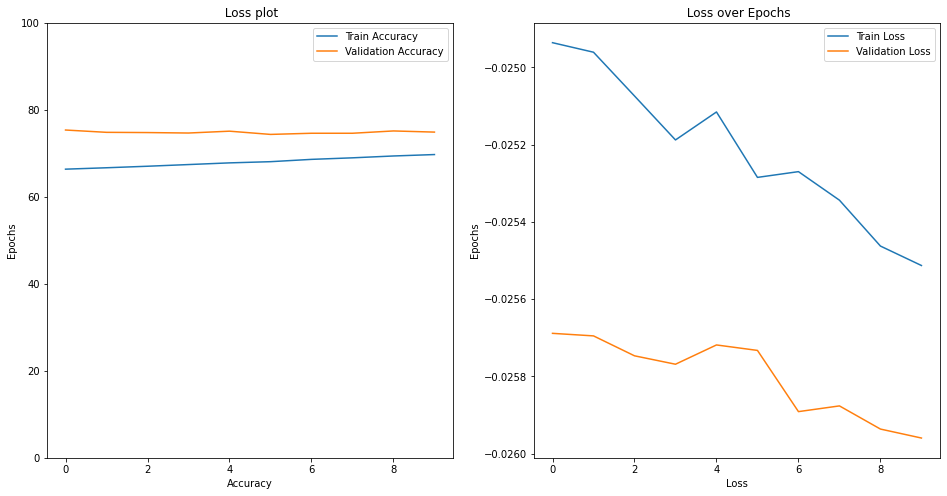

In [31]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-4, momentum=0.9),
               model_name_to_save = 'ResNet18_FL_lr_1e-4',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp9 VGG16 FL adam

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: -0.025419: : 97it [03:54,  2.41s/it]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: -0.026273: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: -0.025681: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: -0.024750: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: -0.023617: : 97it [01:10,  1.38it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: -0.026114: : 97it [01:11,  1.35it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: -0.025693: : 97it [01:12,  1.34it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: -0.026779: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: -0.023047: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: -0.024581: : 97it [01:11,  1.35it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


  0%|          | 0/97 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:05<00:00,  1.48it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,4000,0
Actual covid-19,2200,0


,Predicted Not normal,Predicted normal
Actual Not normal,0,2200
Actual normal,0,4000


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4200,0
Actual pneumonia,2000,0


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,600,0
Actual covid-19,28,0


,Predicted Not normal,Predicted normal
Actual Not normal,0,228
Actual normal,0,400


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,428,0
Actual pneumonia,200,0


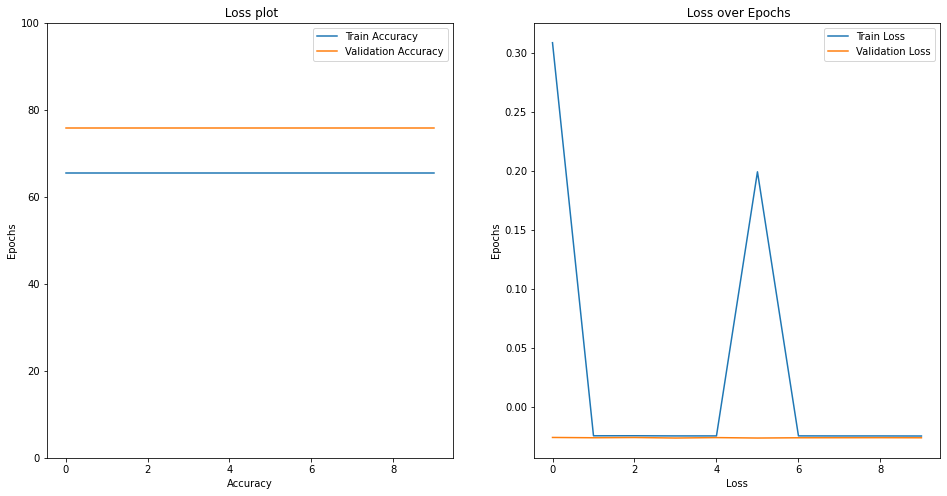

In [0]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.Adam(model_uc.parameters(), lr=1e-2),
               model_name_to_save = 'VGG16_FL_adam',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp10 VGG16 BCELoss Adam

In [0]:
# Load the pretrained model from pytorch
# del vgg16
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.671930: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 65.4 %
	 	 Accuracy Validation images: 75.4 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.605253: : 97it [01:10,  1.38it/s]


	 	 Accuracy Training images: 65.4 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.650071: : 97it [01:11,  1.35it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.655348: : 97it [01:12,  1.35it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.6 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.625521: : 97it [01:11,  1.35it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.706829: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.643894: : 97it [01:12,  1.34it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: 225516.843750: : 97it [01:11,  1.35it/s]


	 	 Accuracy Training images: 65.2 %
	 	 Accuracy Validation images: 75.2 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.669877: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 65.5 %
	 	 Accuracy Validation images: 75.6 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.659940: : 97it [01:12,  1.35it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


  0%|          | 0/97 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:05<00:00,  1.48it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3993,7
Actual covid-19,2198,2


,Predicted Not normal,Predicted normal
Actual Not normal,1,2199
Actual normal,4,3996


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4196,4
Actual pneumonia,1998,2


100%|██████████| 10/10 [00:07<00:00,  1.40it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,599,1
Actual covid-19,28,0


,Predicted Not normal,Predicted normal
Actual Not normal,0,228
Actual normal,1,399


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,427,1
Actual pneumonia,200,0


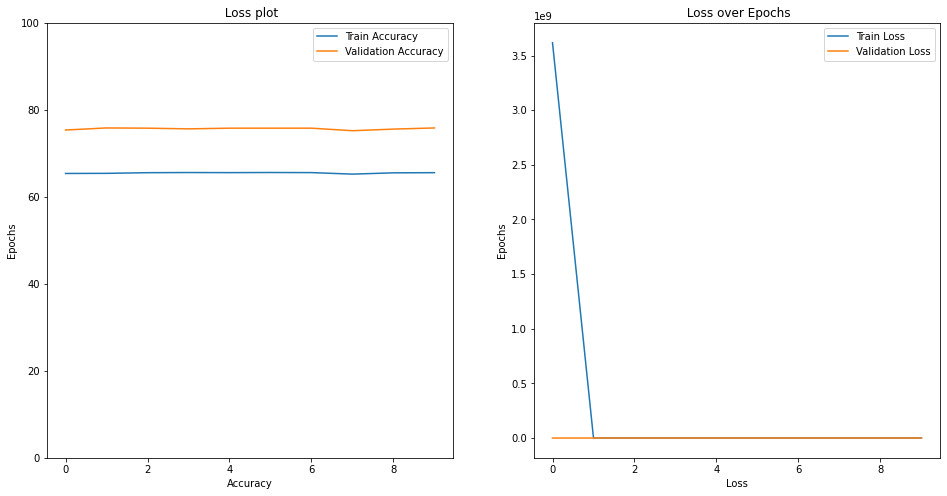

In [0]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.Adam(model_uc.parameters(), lr=1e-2),
               model_name_to_save = 'VGG16 BCELoss Adam',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp11 ResNet18 BCELoss Adam

In [0]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.671436: : 97it [01:01,  1.57it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.7 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.562663: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 76.9 %
	 	 Accuracy Validation images: 76.2 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.552307: : 97it [01:01,  1.57it/s]


	 	 Accuracy Training images: 78.0 %
	 	 Accuracy Validation images: 75.6 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.470588: : 97it [01:02,  1.54it/s]


	 	 Accuracy Training images: 79.2 %
	 	 Accuracy Validation images: 74.9 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.399672: : 97it [01:03,  1.54it/s]


	 	 Accuracy Training images: 79.5 %
	 	 Accuracy Validation images: 75.1 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.486374: : 97it [01:03,  1.53it/s]


	 	 Accuracy Training images: 80.8 %
	 	 Accuracy Validation images: 78.5 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.554710: : 97it [01:03,  1.53it/s]


	 	 Accuracy Training images: 80.3 %
	 	 Accuracy Validation images: 76.8 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.516470: : 97it [01:03,  1.54it/s]


	 	 Accuracy Training images: 78.9 %
	 	 Accuracy Validation images: 74.9 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.493347: : 97it [01:03,  1.53it/s]


	 	 Accuracy Training images: 80.6 %
	 	 Accuracy Validation images: 75.5 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.366536: : 97it [01:03,  1.53it/s]


	 	 Accuracy Training images: 82.1 %


  0%|          | 0/97 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 77.3 %
Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:02<00:00,  1.55it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3579,421
Actual covid-19,716,1484


,Predicted Not normal,Predicted normal
Actual Not normal,1485,715
Actual normal,423,3577


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3774,426
Actual pneumonia,678,1322


100%|██████████| 10/10 [00:06<00:00,  1.45it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,425,175
Actual covid-19,15,13


,Predicted Not normal,Predicted normal
Actual Not normal,152,76
Actual normal,37,363


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,382,46
Actual pneumonia,67,133


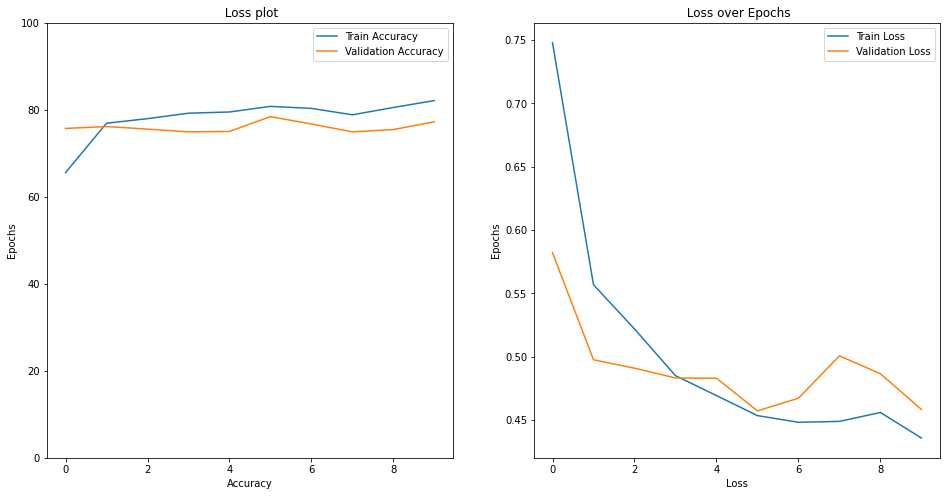

In [0]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.Adam(model_uc.parameters(), lr=1e-2),
               model_name_to_save = 'ResNet18_BCELoss_Adam',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp12 ResNet18 FL Adam

In [0]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: -0.025405: : 97it [01:02,  1.55it/s]


	 	 Accuracy Training images: 65.6 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: -0.026808: : 97it [01:03,  1.53it/s]


	 	 Accuracy Training images: 69.9 %
	 	 Accuracy Validation images: 76.1 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: -0.025808: : 97it [01:02,  1.54it/s]


	 	 Accuracy Training images: 74.7 %
	 	 Accuracy Validation images: 75.2 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: -0.026791: : 97it [01:02,  1.55it/s]


	 	 Accuracy Training images: 76.6 %
	 	 Accuracy Validation images: 76.0 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: -0.026720: : 97it [01:02,  1.54it/s]


	 	 Accuracy Training images: 76.9 %
	 	 Accuracy Validation images: 74.0 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: -0.026472: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 72.9 %
	 	 Accuracy Validation images: 69.9 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: -0.026283: : 97it [01:02,  1.55it/s]


	 	 Accuracy Training images: 74.1 %
	 	 Accuracy Validation images: 69.6 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: -0.026851: : 97it [01:03,  1.54it/s]


	 	 Accuracy Training images: 76.6 %
	 	 Accuracy Validation images: 73.7 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: -0.026811: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 75.4 %
	 	 Accuracy Validation images: 72.2 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: -0.026879: : 97it [01:03,  1.54it/s]


	 	 Accuracy Training images: 77.8 %


  0%|          | 0/97 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 74.8 %
Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:01<00:00,  1.57it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3384,616
Actual covid-19,795,1405


,Predicted Not normal,Predicted normal
Actual Not normal,1428,772
Actual normal,638,3362


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3642,558
Actual pneumonia,809,1191


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,406,194
Actual covid-19,19,9


,Predicted Not normal,Predicted normal
Actual Not normal,147,81
Actual normal,62,338


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,368,60
Actual pneumonia,76,124


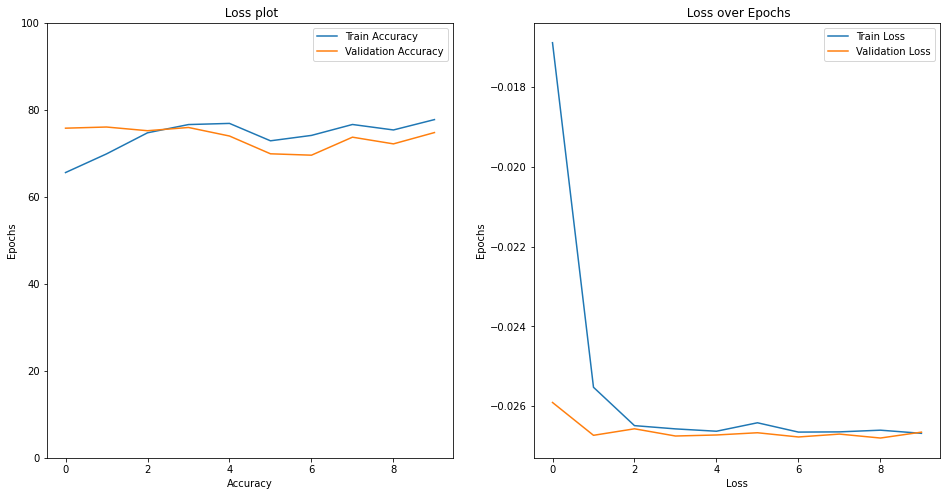

In [0]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.Adam(model_uc.parameters(), lr=1e-2),
               model_name_to_save = 'ResNet18 FL Adam',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp13 VGG16FL lr1e-2 gamma 1.5 

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)
features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: -0.043509: : 97it [01:10,  1.38it/s]


	 	 Accuracy Training images: 81.8 %
	 	 Accuracy Validation images: 78.3 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: -0.042742: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 82.0 %
	 	 Accuracy Validation images: 79.7 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: -0.043225: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 81.9 %
	 	 Accuracy Validation images: 80.9 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: -0.042205: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 83.7 %
	 	 Accuracy Validation images: 79.6 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: -0.043580: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 83.4 %
	 	 Accuracy Validation images: 77.5 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: -0.043534: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 82.0 %
	 	 Accuracy Validation images: 76.5 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: -0.043126: : 97it [01:11,  1.37it/s]


	 	 Accuracy Training images: 84.1 %
	 	 Accuracy Validation images: 81.1 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: -0.043406: : 97it [01:10,  1.37it/s]


	 	 Accuracy Training images: 84.6 %
	 	 Accuracy Validation images: 80.0 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: -0.043466: : 97it [01:10,  1.38it/s]


	 	 Accuracy Training images: 84.8 %
	 	 Accuracy Validation images: 79.5 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: -0.043207: : 97it [01:11,  1.36it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 79.7 %


  0%|          | 0/97 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:04<00:00,  1.50it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3562,438
Actual covid-19,507,1693


,Predicted Not normal,Predicted normal
Actual Not normal,1728,472
Actual normal,456,3544


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3834,366
Actual pneumonia,530,1470


100%|██████████| 10/10 [00:07<00:00,  1.38it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,390,210
Actual covid-19,12,16


,Predicted Not normal,Predicted normal
Actual Not normal,172,56
Actual normal,45,355


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,398,30
Actual pneumonia,51,149


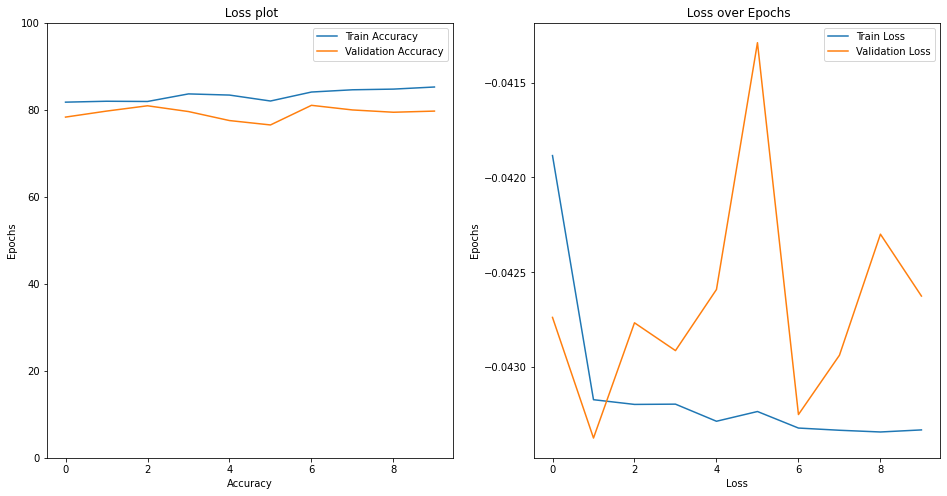

In [0]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=1.5, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'VGG16FL gamma 1.5 ',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp14 ResNet18 FL gamma 1.5

In [0]:
res18 = models.resnet18(pretrained=True)


# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: -0.042164: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 68.6 %
	 	 Accuracy Validation images: 75.0 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: -0.035067: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 78.3 %
	 	 Accuracy Validation images: 78.1 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: -0.042941: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 82.7 %
	 	 Accuracy Validation images: 78.8 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: -0.043533: : 97it [01:02,  1.54it/s]


	 	 Accuracy Training images: 84.2 %
	 	 Accuracy Validation images: 80.1 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: -0.043592: : 97it [01:03,  1.54it/s]


	 	 Accuracy Training images: 84.5 %
	 	 Accuracy Validation images: 78.8 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: -0.043039: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 84.7 %
	 	 Accuracy Validation images: 79.1 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: -0.043430: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 84.8 %
	 	 Accuracy Validation images: 77.8 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: -0.043065: : 97it [01:02,  1.56it/s]


	 	 Accuracy Training images: 84.6 %
	 	 Accuracy Validation images: 78.5 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: -0.043596: : 97it [01:02,  1.54it/s]


	 	 Accuracy Training images: 84.7 %
	 	 Accuracy Validation images: 79.1 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: -0.043478: : 97it [01:02,  1.55it/s]


	 	 Accuracy Training images: 85.6 %


  0%|          | 0/97 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 78.8 %
Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:01<00:00,  1.59it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3563,437
Actual covid-19,485,1715


,Predicted Not normal,Predicted normal
Actual Not normal,1721,479
Actual normal,472,3528


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3879,321
Actual pneumonia,589,1411


100%|██████████| 10/10 [00:06<00:00,  1.50it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,391,209
Actual covid-19,14,14


,Predicted Not normal,Predicted normal
Actual Not normal,179,49
Actual normal,51,349


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,398,30
Actual pneumonia,52,148


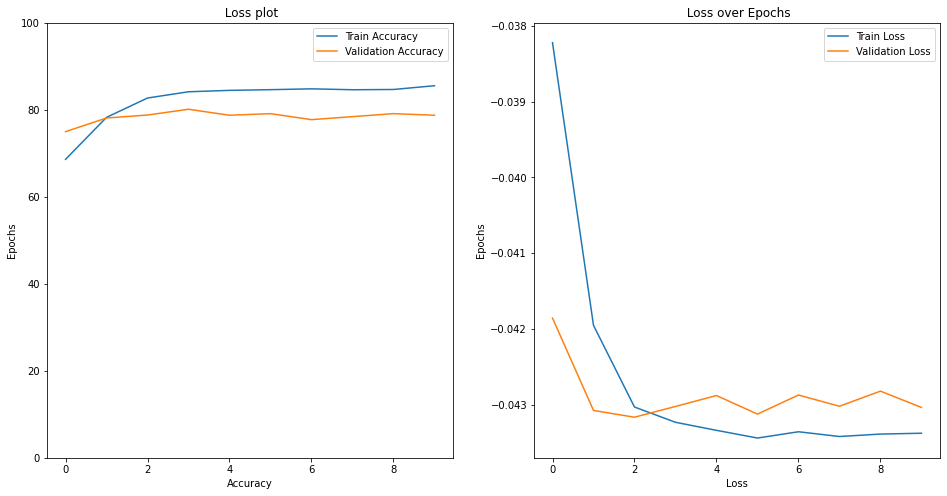

In [0]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=1.5, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'ResNet18 FL gamma 1.5',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp15 VGG16 BCELoss finetune

In [0]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

to_freeze = [0,2,5,10,24,28]

for layer_no in to_freeze:
  for param in vgg16.features[layer_no].parameters():
    param.requires_grad = False

features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.256398: : 97it [01:07,  1.45it/s]


	 	 Accuracy Training images: 87.6 %
	 	 Accuracy Validation images: 82.4 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.227027: : 97it [01:06,  1.45it/s]


	 	 Accuracy Training images: 89.9 %
	 	 Accuracy Validation images: 83.4 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.163213: : 97it [01:06,  1.45it/s]


	 	 Accuracy Training images: 88.5 %
	 	 Accuracy Validation images: 83.2 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.150861: : 97it [01:07,  1.44it/s]


	 	 Accuracy Training images: 90.9 %
	 	 Accuracy Validation images: 83.3 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.240169: : 97it [01:07,  1.44it/s]


	 	 Accuracy Training images: 91.4 %
	 	 Accuracy Validation images: 83.8 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.296875: : 97it [01:06,  1.45it/s]


	 	 Accuracy Training images: 92.2 %
	 	 Accuracy Validation images: 83.8 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.281456: : 97it [01:07,  1.44it/s]


	 	 Accuracy Training images: 89.7 %
	 	 Accuracy Validation images: 81.8 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.532821: : 97it [01:07,  1.44it/s]


	 	 Accuracy Training images: 92.4 %
	 	 Accuracy Validation images: 83.5 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.146352: : 97it [01:07,  1.43it/s]


	 	 Accuracy Training images: 92.5 %
	 	 Accuracy Validation images: 85.2 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.104047: : 97it [01:07,  1.44it/s]


	 	 Accuracy Training images: 92.7 %
	 	 Accuracy Validation images: 84.8 %


  0%|          | 0/97 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:05<00:00,  1.49it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3832,168
Actual covid-19,258,1942


,Predicted Not normal,Predicted normal
Actual Not normal,1937,263
Actual normal,164,3836


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,3941,259
Actual pneumonia,236,1764


100%|██████████| 10/10 [00:07<00:00,  1.43it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,405,195
Actual covid-19,8,20


,Predicted Not normal,Predicted normal
Actual Not normal,200,28
Actual normal,13,387


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,409,19
Actual pneumonia,20,180


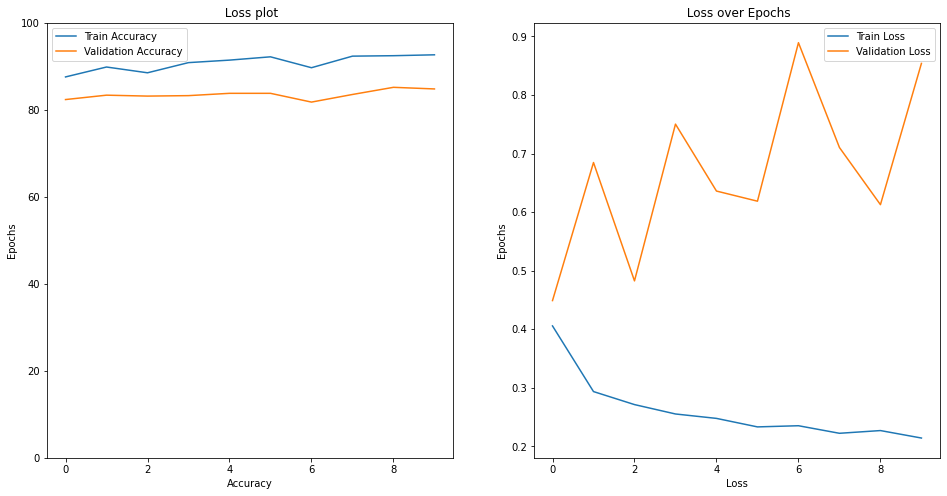

In [0]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'VGG16 BCELoss finetune',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp16 ResNet18 Fine tuning BCElos

In [0]:
res18 = models.resnet18(pretrained=True)
for param in list(res18.children())[-1].parameters():
  param.requires_grad = False

# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

VGG16 Model Training Started 


Train Epoch: 0 [5376/6200 (99%)]	Loss: 0.628029: : 97it [01:02,  1.55it/s]


	 	 Accuracy Training images: 66.0 %
	 	 Accuracy Validation images: 74.9 %


Train Epoch: 1 [5376/6200 (99%)]	Loss: 0.641441: : 97it [01:03,  1.52it/s]


	 	 Accuracy Training images: 65.7 %
	 	 Accuracy Validation images: 75.7 %


Train Epoch: 2 [5376/6200 (99%)]	Loss: 0.570284: : 97it [01:03,  1.52it/s]


	 	 Accuracy Training images: 65.7 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 3 [5376/6200 (99%)]	Loss: 0.506339: : 97it [01:03,  1.53it/s]


	 	 Accuracy Training images: 66.0 %
	 	 Accuracy Validation images: 75.8 %


Train Epoch: 4 [5376/6200 (99%)]	Loss: 0.481659: : 97it [01:04,  1.51it/s]


	 	 Accuracy Training images: 66.4 %
	 	 Accuracy Validation images: 75.6 %


Train Epoch: 5 [5376/6200 (99%)]	Loss: 0.499476: : 97it [01:04,  1.51it/s]


	 	 Accuracy Training images: 67.8 %
	 	 Accuracy Validation images: 75.7 %


Train Epoch: 6 [5376/6200 (99%)]	Loss: 0.458939: : 97it [01:03,  1.52it/s]


	 	 Accuracy Training images: 69.7 %
	 	 Accuracy Validation images: 75.7 %


Train Epoch: 7 [5376/6200 (99%)]	Loss: 0.491834: : 97it [01:04,  1.50it/s]


	 	 Accuracy Training images: 73.3 %
	 	 Accuracy Validation images: 75.6 %


Train Epoch: 8 [5376/6200 (99%)]	Loss: 0.485879: : 97it [01:04,  1.51it/s]


	 	 Accuracy Training images: 76.6 %
	 	 Accuracy Validation images: 76.8 %


Train Epoch: 9 [5376/6200 (99%)]	Loss: 0.453919: : 97it [01:03,  1.52it/s]


	 	 Accuracy Training images: 79.5 %


  0%|          | 0/97 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 78.4 %
Finished Training

  Confusion Matrices :


100%|██████████| 97/97 [01:01<00:00,  1.57it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3844,156
Actual covid-19,1038,1162


,Predicted Not normal,Predicted normal
Actual Not normal,1133,1067
Actual normal,137,3863


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4149,51
Actual pneumonia,1372,628


100%|██████████| 10/10 [00:06<00:00,  1.47it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,464,136
Actual covid-19,26,2


,Predicted Not normal,Predicted normal
Actual Not normal,115,113
Actual normal,7,393


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,426,2
Actual pneumonia,132,68


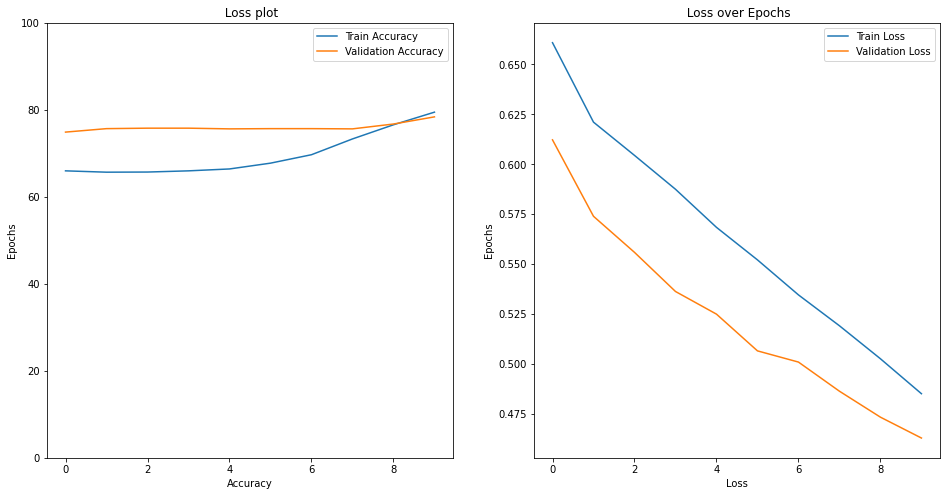

In [0]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = nn.BCEWithLogitsLoss(),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-4, momentum=0.9),
               model_name_to_save = 'ResNet18 Fine tuning BCElos',
               plot_graphs = True)

print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

### Exp17 VGG16 FL Gamma1.5

In [15]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

to_freeze = [0,2,5,10,24,28]

for layer_no in to_freeze:
  for param in vgg16.features[layer_no].parameters():
    param.requires_grad = False

features = list(vgg16.classifier.children())
features.extend([ nn.ReLU(), nn.Linear(1000, len(class_names))])

vgg16.classifier = nn.Sequential(*features)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: -0.043441: : 775it [06:20,  2.03it/s]


	 	 Accuracy Training images: 85.3 %
	 	 Accuracy Validation images: 81.7 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: -0.031725: : 775it [01:20,  9.67it/s]


	 	 Accuracy Training images: 87.2 %
	 	 Accuracy Validation images: 79.9 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: -0.043080: : 775it [01:19,  9.77it/s]


	 	 Accuracy Training images: 88.6 %
	 	 Accuracy Validation images: 80.6 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: -0.043448: : 775it [01:20,  9.68it/s]


	 	 Accuracy Training images: 87.6 %
	 	 Accuracy Validation images: 82.2 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: -0.042859: : 775it [01:19,  9.77it/s]


	 	 Accuracy Training images: 86.9 %
	 	 Accuracy Validation images: 81.3 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: -0.043449: : 775it [01:20,  9.62it/s]


	 	 Accuracy Training images: 88.3 %
	 	 Accuracy Validation images: 79.5 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: -0.043101: : 775it [01:20,  9.62it/s]


	 	 Accuracy Training images: 89.5 %
	 	 Accuracy Validation images: 83.1 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: -0.042693: : 775it [01:21,  9.57it/s]


	 	 Accuracy Training images: 88.6 %
	 	 Accuracy Validation images: 80.5 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: -0.042722: : 775it [01:20,  9.59it/s]


	 	 Accuracy Training images: 89.2 %
	 	 Accuracy Validation images: 81.8 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: -0.041237: : 775it [01:22,  9.41it/s]


	 	 Accuracy Training images: 90.0 %
	 	 Accuracy Validation images: 82.8 %


  0%|          | 0/775 [00:00<?, ?it/s]

Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:11<00:00, 10.86it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3805,195
Actual covid-19,384,1816


,Predicted Not normal,Predicted normal
Actual Not normal,1836,364
Actual normal,206,3794


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4013,187
Actual pneumonia,535,1465


100%|██████████| 79/79 [00:07<00:00, 10.66it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,420,180
Actual covid-19,13,15


,Predicted Not normal,Predicted normal
Actual Not normal,187,41
Actual normal,13,387


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,422,6
Actual pneumonia,46,154


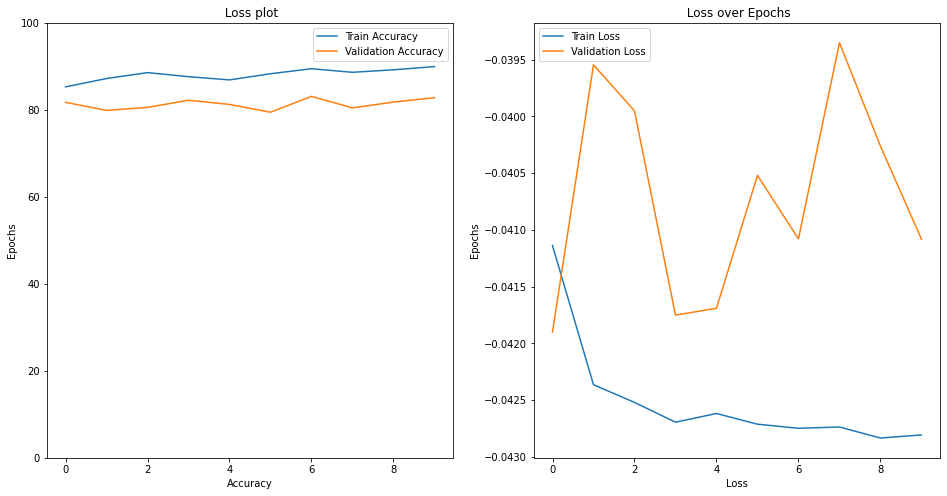

In [16]:
model_uc = vgg16

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=1.5, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'VGG16 Focal Loss finetune_a',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)

In [17]:
testing_predictions_to_csv (testloader, 'Testing', model_uc)

100%|██████████| 629/629 [03:07<00:00,  3.36it/s]


### Exp18 ResNet18 FL Gamma 2

In [18]:
res18 = models.resnet18(pretrained=True)
for param in list(res18.children())[-1].parameters():
  param.requires_grad = False

# Changing FCL 

features = nn.Sequential(nn.Linear(512, 512),
                         nn.ReLU(),
                         nn.Linear(512, 3)
                         )
res18.fc =  features

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


VGG16 Model Training Started 


Train Epoch: 0 [6192/6200 (100%)]	Loss: -0.026594: : 775it [01:06, 11.64it/s]


	 	 Accuracy Training images: 81.3 %
	 	 Accuracy Validation images: 77.2 %


Train Epoch: 1 [6192/6200 (100%)]	Loss: -0.026807: : 775it [01:06, 11.58it/s]


	 	 Accuracy Training images: 83.0 %
	 	 Accuracy Validation images: 77.4 %


Train Epoch: 2 [6192/6200 (100%)]	Loss: -0.026817: : 775it [01:06, 11.61it/s]


	 	 Accuracy Training images: 83.4 %
	 	 Accuracy Validation images: 76.9 %


Train Epoch: 3 [6192/6200 (100%)]	Loss: -0.026852: : 775it [01:06, 11.63it/s]


	 	 Accuracy Training images: 83.5 %
	 	 Accuracy Validation images: 76.4 %


Train Epoch: 4 [6192/6200 (100%)]	Loss: -0.026393: : 775it [01:06, 11.57it/s]


	 	 Accuracy Training images: 83.6 %
	 	 Accuracy Validation images: 75.9 %


Train Epoch: 5 [6192/6200 (100%)]	Loss: -0.026828: : 775it [01:08, 11.38it/s]


	 	 Accuracy Training images: 84.1 %
	 	 Accuracy Validation images: 78.0 %


Train Epoch: 6 [6192/6200 (100%)]	Loss: -0.026817: : 775it [01:07, 11.50it/s]


	 	 Accuracy Training images: 83.9 %
	 	 Accuracy Validation images: 79.4 %


Train Epoch: 7 [6192/6200 (100%)]	Loss: -0.026674: : 775it [01:07, 11.47it/s]


	 	 Accuracy Training images: 84.1 %
	 	 Accuracy Validation images: 76.6 %


Train Epoch: 8 [6192/6200 (100%)]	Loss: -0.026832: : 775it [01:07, 11.49it/s]


	 	 Accuracy Training images: 85.0 %
	 	 Accuracy Validation images: 77.4 %


Train Epoch: 9 [6192/6200 (100%)]	Loss: -0.026543: : 775it [01:07, 11.54it/s]


	 	 Accuracy Training images: 84.0 %


  0%|          | 0/775 [00:00<?, ?it/s]

	 	 Accuracy Validation images: 78.0 %
Finished Training

  Confusion Matrices :


100%|██████████| 775/775 [01:02<00:00, 12.34it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,3370,630
Actual covid-19,374,1826


,Predicted Not normal,Predicted normal
Actual Not normal,1816,384
Actual normal,615,3385


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,4041,159
Actual pneumonia,867,1133


100%|██████████| 79/79 [00:06<00:00, 12.35it/s]


,Predicted Not covid-19,Predicted covid-19
Actual Not covid-19,367,233
Actual covid-19,15,13


,Predicted Not normal,Predicted normal
Actual Not normal,187,41
Actual normal,56,344


,Predicted Not pneumonia,Predicted pneumonia
Actual Not pneumonia,411,17
Actual pneumonia,76,124


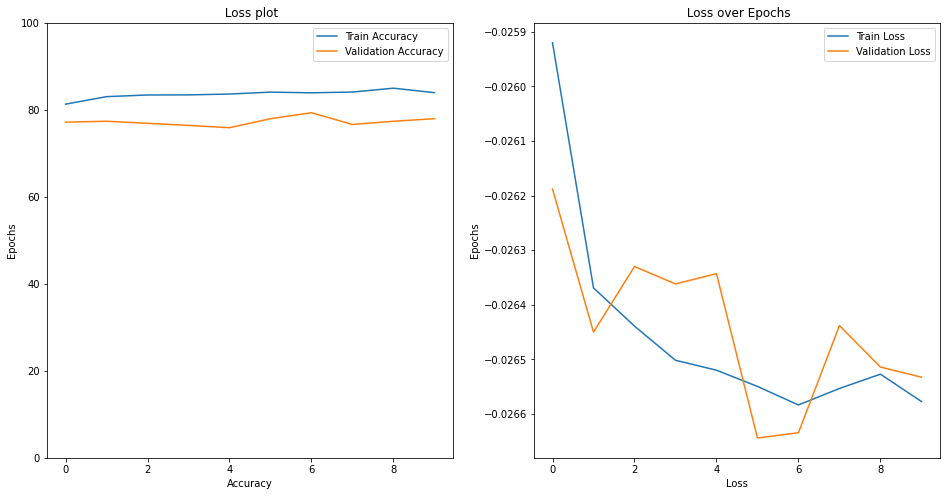

In [19]:
model_uc = res18

print( 'VGG16 Model Training Started ')
model_training(model_loaded = model_uc,
               train_data_loader = trainloader ,
               validation_data_loader = validationloader,
               no_of_epochs =10,
               criterion_function = FocalLoss(gamma=2, alpha=0.25),
               optimizer_function = optim.SGD(model_uc.parameters(), lr=1e-2, momentum=0.9),
               model_name_to_save = 'ResNet Focal Loss finetune_a',
               plot_graphs = True)



print('\n  Confusion Matrices :')
Confusion_Matrix_F1(trainloader      , "Training"  , model_uc)
Confusion_Matrix_F1(validationloader , "Validation", model_uc)